# Optimización de Parámetros

In [18]:
## Get current work directory to load all the custom modules
from pathlib import Path
import sys
BASE_DIR = Path().absolute().resolve(strict=True).parent.parent.parent
if str(BASE_DIR) not in sys.path:
    sys.path.append(str(BASE_DIR))

In [19]:
DATA_PATH = os.path.join(BASE_DIR, 'data', 'gruas')
print(DATA_PATH)

/workspace/Externos/TimeSeries/BenchMark/data/gruas


In [20]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

In [35]:
import statsmodels.api as sm
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import optuna
import datetime

In [22]:
from helpers.general import  print_forecasting_results

In [23]:
data = pd.read_csv(os.path.join(DATA_PATH, 'producto.csv'), parse_dates=['Periodo'])
data.head()

,idArticulo,ventas,DescProducto,Periodo
0,tuerc,7,TUERCA,2021-05-01
1,tuerc,5,TUERCA,2020-12-01
2,tuerc,1,TUERCA,2020-11-01
3,tuerc,11,TUERCA,2020-09-01
4,tuerc,4,TUERCA,2020-06-01


In [24]:
data['Periodo'][0]

Timestamp('2021-05-01 00:00:00')

In [25]:
# Pivotando las tablas y llenando de ceros las ventas que no existen.
imp_mean = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
df_time_pre = data.pivot_table(index='Periodo', columns='idArticulo', values='ventas', aggfunc='sum', )
df_time = imp_mean.fit_transform(df_time_pre)
df_time = pd.DataFrame(df_time, columns=df_time_pre.columns, index=df_time_pre.index)
df_time.tail()

idArticulo,arandel,bateriascanrec,filtrodeair,filtrodepresio,filtroderetorn,pern,soport,tuerc
Periodo,,,,,,,,
2021-06-01,0.0,0.0,2.0,2.0,4.0,0.0,0.0,0.0
2021-07-01,0.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0
2021-08-01,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2021-09-01,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
2021-10-01,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0


### Colocando frecuencia de tiempo mensual

In [26]:
# df_time.index = pd.DatetimeIndex(df_time.index).to_period('M')

## Optimizando un solo Producto

## Baseline ARIMA

In [27]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 2016-04-01 to 2021-10-01
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   arandel         57 non-null     float64
 1   bateriascanrec  57 non-null     float64
 2   filtrodeair     57 non-null     float64
 3   filtrodepresio  57 non-null     float64
 4   filtroderetorn  57 non-null     float64
 5   pern            57 non-null     float64
 6   soport          57 non-null     float64
 7   tuerc           57 non-null     float64
dtypes: float64(8)
memory usage: 4.0 KB


R2 = 0.433739476546548


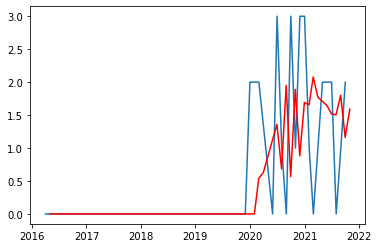

In [46]:
def total_forecasting(data, ar=2, ii=1, ma=2):
    """
    Forecasting using ARIMA model.
    """
    df = data.copy()
    df.index = pd.DatetimeIndex(df.index).to_period('M')
    model = ARIMA(df, order=(ar,ii,ma))
    results = model.fit()
    return results.fittedvalues
    
idArticulo = 'filtrodeair'
result = total_forecasting(df_time[[idArticulo]])
r2 = r2_score(df_time[idArticulo], result)
print(f"R2 = {r2}")
_ = plt.plot(df_time[[idArticulo]])
_ = plt.plot(result , color='red')
    

# Optimización por [OPTUNA](https://github.com/optuna/optuna/blob/40b097650d312913989b5825aa9c9adf4b15c396/docs/source/index.rst)

In [53]:
# You can increase iteration number.
iteration = 200

optuna.logging.disable_default_handler() # not display log
#optuna.logging.enable_default_handler() # display log

In [54]:

%%time

def objective(trial):
    r_min = 0
    r_max = 10
    ar = trial.suggest_int('ar', r_min, r_max)
    ii = trial.suggest_int('ii', r_min, r_max)
    ma = trial.suggest_int('ma', r_min, r_max)
    idArticulo = 'filtrodeair'
    pred = total_forecasting(df_time[[idArticulo]], ar, ii, ma)
    score = r2_score(df_time[idArticulo], pred)
    #print('a:%1.3f,b:%1.3f,c:%1.3f,d:%1.3f,e:%1.3f,score %1.3f' % (a,b,c,d,e,score))
    return score
SEED=5050
#study = optuna.create_study(direction='maximize')
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=iteration)

/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/dave-linux/.lo

CPU times: user 19min 50s, sys: 18min 49s, total: 38min 39s
Wall time: 5min 11s


/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [55]:
study.best_value

0.6219214612143515

In [56]:
study.best_params

{'ar': 7, 'ii': 1, 'ma': 10}

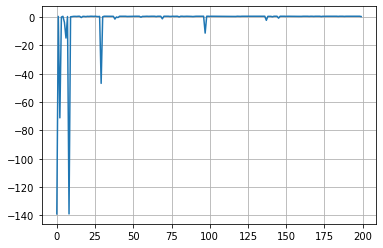

In [57]:
plt.plot([trial.value for trial in study.trials])
plt.grid()
plt.show()